# Sentiment Analysis on Disneyland Resort Reviews

In this example, we will extract valuable sentiments from Disneyland Resort reviews, gaining a deeper understanding of customer experiences. 

We will leverage the power of Natural Language Processing (NLP) and sentiment analysis techniques to assess the sentiment expressed in these reviews. But that's not all, our approach doesn't stop at sentiment analysis; it extends to the realm of powerful vector databases.

Using KDB.AI we can store not only the reviews themselves but also the sentiment labels as metadata. With KDB.AI, we can easily search for any topic, keyword, or sentiment and retrieve relevant customer reviews instantly. Whether you're interested in finding the happiest moments in the park, uncovering areas for improvement, or simply exploring the multitude of experiences Disneyland Resort has to offer, KDB.AI makes it all possible with just a few clicks.

### Aim 

In the sections that follow, we'll walk you through the entire process:

1. Load Review Data
1. Perform Sentiment Analysis On The Reviews
1. Create Review Vector Embeddings
1. Store Embeddings in KDB.AI
1. Search For Similar Reviews To A Target Review
1. Delete the KDB.AI Table

By the end of this tutorial, you'll not only have a deeper understanding of sentiment analysis but also the tools and knowledge to harness the insights hidden within vast datasets of customer reviews. Let's embark on this journey to uncover the magic and meaning behind Disneyland Resort reviews with sentiment analysis and KDB.AI.

---

## 0. Setup

### Import Packages

In [1]:
import pandas as pd
from tqdm.notebook import tqdm

In [2]:
# tokenisation
from transformers import pipeline
from transformers import AutoTokenizer
from transformers import AutoModelForSequenceClassification

2023-09-20 02:11:04.385287: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-20 02:11:04.438306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-20 02:11:05.359709: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
# embedding
from sentence_transformers import SentenceTransformer

In [5]:
# vector DB
import os
import kdbai_client as kdbai
from getpass import getpass
import time

### Configure Console

In [6]:
pd.set_option("display.max_colwidth", 200)

### Define Helper Functions

In [7]:
def show_df(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    return df.head()

## 1. Load Review Data 

### Dataset Overview

The dataset that will be used for this example is these [Disneyland Reviews](https://www.kaggle.com/datasets/arushchillar/disneyland-reviews) available on Kaggle. The dataset includes 42,000 reviews of 3 Disneyland branches - Paris, California and Hong Kong, posted by visitors on Trip Advisor.

### Read In Review Data From CSV

In [8]:
raw_reviews_df = pd.read_csv("data/disneyland_reviews.csv", encoding="ISO-8859-1")

In [9]:
show_df(raw_reviews_df)

(42656, 6)


,Review_ID,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,4,2019-4,Australia,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides its a Small Wo...,Disneyland_HongKong
1,670682799,4,2019-5,Philippines,"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironm...",Disneyland_HongKong
2,670623270,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid when I was visiting the park otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunat...,Disneyland_HongKong
3,670607911,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work going on at present so a number of areas are closed off (including the famous castle) If you go midwee...,Disneyland_HongKong
4,670607296,4,2019-4,United Kingdom,"the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much, everything is fine. but its really crowded and hot in Hong Kong",Disneyland_HongKong


### Subset The Data

This is a pretty big dataset and we do not need to use all of this in our sample. As such, we will extract a subset of these reviews.

Let's first take a look at the number of reviews per branch.

In [10]:
raw_reviews_df.groupby("Branch")["Branch"].count()

Branch
Disneyland_California    19406
Disneyland_HongKong       9620
Disneyland_Paris         13630
Name: Branch, dtype: int64

We have a good number per branch so let's take the first 50 per branch only to help with performance.

The speed of your hardware, particularly your CPU and memory, will influence processing time when running sentiment analysis. If you are running this example on a CPU it is a good idea to restrict the number of rows first to help with performance. If you have access to a GPU you may wish to use that and the full dataset.

In [11]:
reviews_df = raw_reviews_df.groupby("Branch").head(50)

In [12]:
reviews_df.groupby("Branch")["Branch"].count()

Branch
Disneyland_California    50
Disneyland_HongKong      50
Disneyland_Paris         50
Name: Branch, dtype: int64

## 2. Perform Sentiment Analysis On The Reviews

Sentiment analysis, the process of determining the emotional tone or sentiment expressed in text, has seen significant advancements with the use of transformer-based models. In this section, we explore sentiment analysis using the powerful [Hugging Face Transformers](https://huggingface.co/docs/transformers/model_doc/roberta) library.

### Import Sentence Tokenizer And Model

We begin by importing essential components, including the sentiment analysis model and tokenizer. In this example, we use the RoBERTa model, which is fine-tuned for sentiment classification tasks. The model is capable of classifying text into three sentiment labels: positive, negative, and neutral.

Key Components:

- **AutoModelForSequenceClassification**: This component is a pre-trained transformer model fine-tuned for sequence classification tasks like sentiment analysis. It's designed to handle various NLP tasks, making it highly versatile.
- **AutoTokenizer**: We use the tokenizer to preprocess and encode text data before feeding it to the model.
- **MODEL**: This variable specifies the pre-trained sentiment analysis model we're using in this example.

In [13]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

In [14]:
tokenizer = AutoTokenizer.from_pretrained(MODEL)

In [15]:
sentiment_model = AutoModelForSequenceClassification.from_pretrained(
    MODEL, num_labels=3
)

### Configure Sentiment Analysis Model Pipeline

In this section, we configure the sentiment analysis pipeline using the Hugging Face Transformers library. 

This configuration enables us to easily perform sentiment analysis on text data by utilizing the pre-trained model within the pipeline. The 'sentiment' function streamlines the process of obtaining sentiment labels and scores, making it convenient for analyzing reviews or textual data and interpreting the sentiment expressed within them.

In [16]:
sentiment_pipeline = pipeline(
    "sentiment-analysis",
    model=sentiment_model,
    tokenizer=tokenizer,
)

In [17]:
def sentiment(reviews):
    # pass the reviews through sentiment analysis pipeline
    sentiments = sentiment_pipeline(reviews)
    # extract only the label and score from the result
    l = [labels[x["label"]] for x in sentiments][0]
    s = [x["score"] for x in sentiments][0]
    return l, s

In [18]:
labels = {"LABEL_0": "negative", "LABEL_1": "neutral", "LABEL_2": "positive"}

### Get Sentiment For One Review

In [19]:
example = reviews_df["Review_Text"][10]
example

"Disneyland never cease to amaze me! I've been to Disneyland florida and I thought I have exhausted the kid in me but nope! I still had so much fun in disneyland hong kong. 2 DL off my bucketlist and more to come!     "

In [20]:
sentiment(example)

('positive', 0.9825873970985413)

We can see that the Roberta Model has identified this as a very positive score which makes sense when reading the text.

Great - now let's run our pipeline on the entire dataset.

### Get Sentiment For Entire DataFrame

In this code snippet, we perform sentiment analysis on the entire DataFrame containing reviews. 

The process involves iterating through each row of the DataFrame, extracting text data, and using a sentiment analysis function `sentiment` to analyze the sentiment of each review. Additionally, it includes error handling to gracefully handle any issues that may arize during the sentiment analysis process.

This code will take a few minutes to run - you can always reduce or increase the size of the input data depending on your machines performance.

In [21]:
res = {}
for _, row in tqdm(reviews_df.iterrows(), total=len(reviews_df)):
    myid = row["Review_ID"]
    try:
        res[myid] = sentiment(row["Review_Text"])
    except RuntimeError:
        print(f"Broke for id {myid}")

  0%|          | 0/150 [00:00<?, ?it/s]

Broke for id 668777351
Broke for id 669706763
Broke for id 667308717


We can see it broke for some IDs which is okay - these may have been too long for the RoBERTa model and have been ignored.

Let's merge the sentiment analysis results obtained from the sentiment analysis process with the original DataFrame.

In [22]:
sentiments_df = (
    pd.DataFrame(res)
    .T.reset_index()
    .rename(columns={"index": "Review_ID", 0: "Label", 1: "Score"})
)

In [23]:
show_df(sentiments_df)

(147, 3)


,Review_ID,Label,Score
0,670772142,positive,0.984786
1,670682799,positive,0.858987
2,670623270,positive,0.898818
3,670607911,positive,0.863198
4,670607296,positive,0.56407


### Add These Sentiment Values To The Reviews

In [24]:
review_sentiments_df = sentiments_df.merge(reviews_df, how="left")

In [25]:
show_df(review_sentiments_df)

(147, 8)


,Review_ID,Label,Score,Rating,Year_Month,Reviewer_Location,Review_Text,Branch
0,670772142,positive,0.984786,4,2019-4,Australia,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides its a Small Wo...,Disneyland_HongKong
1,670682799,positive,0.858987,4,2019-5,Philippines,"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironm...",Disneyland_HongKong
2,670623270,positive,0.898818,4,2019-4,United Arab Emirates,Thanks God it wasn t too hot or too humid when I was visiting the park otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunat...,Disneyland_HongKong
3,670607911,positive,0.863198,4,2019-4,Australia,HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work going on at present so a number of areas are closed off (including the famous castle) If you go midwee...,Disneyland_HongKong
4,670607296,positive,0.56407,4,2019-4,United Kingdom,"the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much, everything is fine. but its really crowded and hot in Hong Kong",Disneyland_HongKong


### Plot The Sentiment For Each Branch

Visualizing this, we can see the variety in sentiment across the 3 branches and compare the the rating the customer gave in their review. For the positive reviews we see all 4* or 5* reviews which makes sense. The negative reviews have lower ratings with the California branch getting the lowest ratings off all branches.

<Axes: xlabel='Label', ylabel='Rating'>

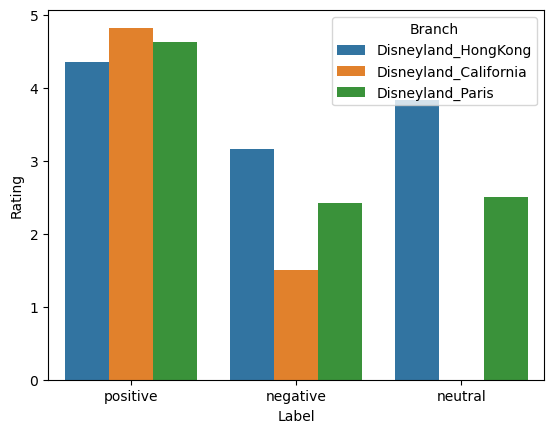

In [26]:
sns.barplot(
    data=review_sentiments_df, x="Label", y="Rating", hue="Branch", errorbar=None
)

 This consolidated dataset can be further analyzed, visualized, and in this example we will add it to our KDB.AI vector database to gain insights into the sentiments expressed in the reviews.

## 3. Create Review Vector Embeddings

Before we can add this data to KDB.AI, we must utilize the [Sentence Transformers](https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2) library to perform text embedding. Text embedding is the process of converting textual data into numerical vectors that capture semantic meaning.

The `embedded_review_df` DataFrame provides a combined view of the original data we want to store as metadata in KDB.AI and the associated embeddings.

In [27]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [28]:
def encode_text(text):
    return embedding_model.encode(text)

In [29]:
review_sentiments_df["embeddings"] = review_sentiments_df["Review_Text"].apply(
    encode_text
)

In [30]:
embedded_review_df = review_sentiments_df[
    ["Branch", "Label", "Score", "Rating", "Review_Text", "embeddings"]
]

In [31]:
show_df(embedded_review_df)

(147, 6)


,Branch,Label,Score,Rating,Review_Text,embeddings
0,Disneyland_HongKong,positive,0.984786,4,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides its a Small Wo...,"[0.12519372, -0.047441892, 0.08718408, 0.010215117, -0.048024543, 0.003773685, 0.0026168323, -0.05580008, -0.0147038605, -0.02043803, 0.003935887, -0.026021171, -0.006516183, -0.017566415, 0.06614..."
1,Disneyland_HongKong,positive,0.858987,4,"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironm...","[0.047256045, -0.022195438, 0.12704656, -0.017679928, 0.012125668, 0.023794485, 0.06356315, -0.058635384, -0.07302155, -0.020539565, -0.019598711, -0.0727139, -0.04178501, -0.0031552715, 0.0726895..."
2,Disneyland_HongKong,positive,0.898818,4,Thanks God it wasn t too hot or too humid when I was visiting the park otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunat...,"[0.102995716, 0.018655345, 0.12572221, 0.08505049, 0.005007115, -0.03478093, -0.017856726, -0.027097583, -0.06612959, -0.045089297, -0.054861, -0.006485136, -0.026050534, 0.017010141, 0.076015055,..."
3,Disneyland_HongKong,positive,0.863198,4,HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work going on at present so a number of areas are closed off (including the famous castle) If you go midwee...,"[0.14166495, -0.016745627, 0.08668989, 0.008527181, -0.037891142, 0.052252654, 0.010436036, -0.045326773, -0.07340576, 0.0044011488, 0.012121074, -0.022934409, -0.039868698, -0.03126053, 0.1209039..."
4,Disneyland_HongKong,positive,0.56407,4,"the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much, everything is fine. but its really crowded and hot in Hong Kong","[0.11346175, 0.004491506, 0.065638095, 0.05553022, 0.027315821, -0.0062374542, -0.078889824, -0.07142627, -0.04667327, 0.011053055, 0.081861004, -0.104370974, -0.03234411, 0.007316668, 0.08222015,..."


## 4. Store Embeddings in KDB.AI

With the embeddings created, we need to store them in a vector database to enable efficient searching. KDB.AI is perfect for this task.

### Connect to KDB.AI Session

To use KDB.AI, you will need two session details - a URL endpoint and an API key. To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI session using `kdbai.Session` and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables `KDBAI_ENDPOINTS` and `KDBAI_API_KEY` exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect.
If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

In [32]:
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

In [33]:
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

### Define Vector DB Table Schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings.

At this point you will select the index and metric you want to use for searching.

In [34]:
review_schema = {
    "columns": [
        {"name": "Branch", "pytype": "str"},
        {"name": "Label", "pytype": "str"},
        {"name": "Score", "pytype": "float64"},
        {"name": "Rating", "pytype": "int64"},
        {"name": "Review_Text", "pytype": "str"},
        {
            "name": "embeddings",
            "vectorIndex": {"dims": 384, "metric": "CS", "type": "hnsw"},
        },
    ]
}

### Create Vector DB Table

Use the KDB.AI `create_table` function to create a table that matches the defined schema in the vector database.

In [35]:
# First ensure the table does not already exist
try:
    session.table("review").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [36]:
table = session.create_table("review", review_schema)

### Add Embedded Data to KDB.AI Table

In [37]:
table.insert(embedded_review_df)

True

### Verify Data Has Been Inserted

Running `table.query()` should show us that data has been added.

In [38]:
show_df(table.query())

(147, 6)


,Branch,Label,Score,Rating,Review_Text,embeddings
0,Disneyland_HongKong,positive,0.984786,4,If you've ever been to Disneyland anywhere you'll find Disneyland Hong Kong very similar in the layout when you walk into main street! It has a very familiar feel. One of the rides its a Small Wo...,"[0.12519372, -0.047441892, 0.08718408, 0.010215117, -0.048024543, 0.003773685, 0.0026168323, -0.05580008, -0.0147038605, -0.02043803, 0.003935887, -0.026021171, -0.006516183, -0.017566415, 0.06614..."
1,Disneyland_HongKong,positive,0.858987,4,"Its been a while since d last time we visit HK Disneyland .. Yet, this time we only stay in Tomorrowland .. AKA Marvel land!Now they have Iron Man Experience n d Newly open Ant Man n d Wasp!!Ironm...","[0.047256045, -0.022195438, 0.12704656, -0.017679928, 0.012125668, 0.023794485, 0.06356315, -0.058635384, -0.07302155, -0.020539565, -0.019598711, -0.0727139, -0.04178501, -0.0031552715, 0.0726895..."
2,Disneyland_HongKong,positive,0.898818,4,Thanks God it wasn t too hot or too humid when I was visiting the park otherwise it would be a big issue (there is not a lot of shade).I have arrived around 10:30am and left at 6pm. Unfortunat...,"[0.102995716, 0.018655345, 0.12572221, 0.08505049, 0.005007115, -0.03478093, -0.017856726, -0.027097583, -0.06612959, -0.045089297, -0.054861, -0.006485136, -0.026050534, 0.017010141, 0.076015055,..."
3,Disneyland_HongKong,positive,0.863198,4,HK Disneyland is a great compact park. Unfortunately there is quite a bit of maintenance work going on at present so a number of areas are closed off (including the famous castle) If you go midwee...,"[0.14166495, -0.016745627, 0.08668989, 0.008527181, -0.037891142, 0.052252654, 0.010436036, -0.045326773, -0.07340576, 0.0044011488, 0.012121074, -0.022934409, -0.039868698, -0.03126053, 0.1209039..."
4,Disneyland_HongKong,positive,0.564070,4,"the location is not in the city, took around 1 hour from Kowlon, my kids like disneyland so much, everything is fine. but its really crowded and hot in Hong Kong","[0.11346175, 0.004491506, 0.065638095, 0.05553022, 0.027315821, -0.0062374542, -0.078889824, -0.07142627, -0.04667327, 0.011053055, 0.081861004, -0.104370974, -0.03234411, 0.007316668, 0.08222015,..."


## 5. Search For Similar Reviews To A Target Review

### Retrieve Reviews Based On A Query

Next, let's create a function to let us perform a search, retrieve relevant results, and return them in Pandas DataFrame format, allowing for further analysis or examination of the retrieved data.

In [39]:
def search_and_extract_results(
    table, embedding_model, search_term: str, n_results: int
) -> pd.DataFrame:
    # Encode the search term
    embedded_search_term = [embedding_model.encode(search_term).tolist()]

    # Perform the search
    search_results = table.search(embedded_search_term, n=n_results)

    # Extract the results to a DataFrame - Return None if no results are found
    return search_results[0].drop("embeddings", axis=1) if search_results else None

Let's try with a query, calling with the search term "are customers satisfied with the food at the park?" and requesting 10 results. 

In [40]:
query1 = "are customers satisfied with the food at the park?"

In [41]:
query1_results = search_and_extract_results(
    table, embedding_model, query1, n_results=10
)

In [42]:
show_df(query1_results)

(25, 6)


,Branch,Label,Score,Rating,Review_Text,__nn_distance
0,Disneyland_Paris,negative,0.914860,2,"Visited the Park today 20 4 and can conclude that they simply let too many people in. Already at opening, queues at the attractions where 1 hour plus. At midday the so called fast track was ...",0.600825
1,Disneyland_California,positive,0.763060,5,"I wish they had better food restaurant choices, but the attractions make up for this deficit so it's all good.",0.568034
2,Disneyland_California,positive,0.962652,5,We found this park to provide family friendly fun with a variety of shows and rides. We pre paid our tickets to save time which was a benefit and were glad we paid extra for the park hopper ticket...,0.492384
3,Disneyland_Paris,negative,0.450606,3,"Don't get my wrong, my family have been to Disneyland Paris twice in as many years, my kids love it and the atmosphere is unique. I think its going a bit far to call it magical though. I wont comm...",0.483248
4,Disneyland_Paris,positive,0.925374,5,"Not the same as Disney in the states, none of the usual foods but none the less still fun. We had a great time.",0.481315


### Group These Reviews By Branch

This functions provides a convenient way to perform sentiment analysis on reviews or data associated with different branches or contexts, aggregating sentiment counts for each branch based on a given search term. 

It enables insights into the sentiments expressed in reviews within specific contexts, which can be valuable for analyzing customer feedback and making data-driven decisions.

In [43]:
def sentiment_counts_by_branch(search_results: pd.DataFrame) -> pd.DataFrame:
    def sentiment_counts(df: pd.DataFrame) -> dict:
        # Store count of sentiment labels
        sentiments = {
            "negative": 0,
            "neutral": 0,
            "positive": 0,
        }
        # Iterate through search results
        for _, row in df.iterrows():
            # Extract the sentiment label and increase its count
            label = row["Label"]
            sentiments[label] += 1
        return sentiments

    grouped_df = search_results.groupby("Branch").apply(sentiment_counts).reset_index()
    grouped_df.columns = ["Branch", "Sentiments"]
    return grouped_df

In [44]:
sentiment_counts_by_branch(query1_results)

,Branch,Sentiments
0,Disneyland_California,"{'negative': 1, 'neutral': 0, 'positive': 7}"
1,Disneyland_HongKong,"{'negative': 0, 'neutral': 0, 'positive': 2}"
2,Disneyland_Paris,"{'negative': 7, 'neutral': 0, 'positive': 8}"


### Visualize The Sentiment Of These Reviews

To further improve the interpretability of the results let's define some functions for visualization.

In [45]:
def plot_sentiment(df: pd.DataFrame, search_term: str) -> None:
    # Iterate through the branches and create separate DataFrames
    final_df = pd.DataFrame()
    for _, row in df.iterrows():
        # Create a DataFrame from the sentiment_counts dictionary
        sentiment_df = pd.DataFrame([row["Sentiments"]])

        # Add a "Branch" column to identify the branch
        sentiment_df["Branch"] = row["Branch"]

        # Concatenate all DataFrames into one
        final_df = pd.concat([final_df, sentiment_df], ignore_index=True)

    # Melt the DataFrame for easier plotting
    final_df = final_df.melt(
        id_vars=["Branch"], var_name="Sentiment", value_name="Count"
    )

    # Create a bar plot with different colors per Branch and a legend
    plt.figure(figsize=(10, 4))
    sns.barplot(x="Sentiment", y="Count", hue="Branch", data=final_df)
    plt.title(search_term)
    plt.ylabel("Number of Reviews")
    plt.xticks(rotation=45)
    plt.legend(title="Branch", loc="upper right")
    plt.show()

In [46]:
# Guest satisfaction with rides and attractions
query2 = "what did guests think of the rides and attractions?"

In [47]:
# find reviews based on this query
query2_results = search_and_extract_results(
    table, embedding_model, query2, n_results=50
)

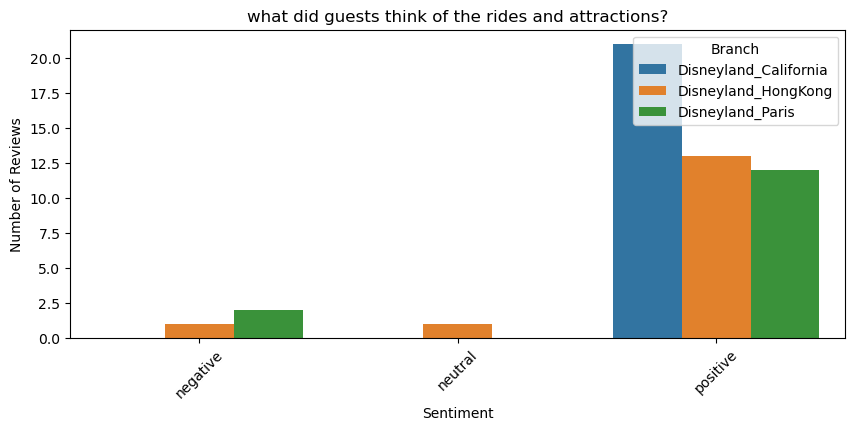

In [48]:
# visualize the sentiment of similar reviews
plot_sentiment(sentiment_counts_by_branch(query2_results), query2)

We can see the guests are extremely satisfied with the rides and attractions at all 3 branches with Disneyland California coming out on top with no negative reviews related to rides and attractions.

### Automate This Sentiment Of Review process

In [49]:
def review_sentiment_for_query(
    table, embedding_model, query: str, n_results: int
) -> None:
    # find similar reviews
    query1_results = search_and_extract_results(
        table, embedding_model, query, n_results=n_results
    )

    # top 3 most similar
    print(query1_results[:3]["Review_Text"])

    # sentiment of similar reviews
    plot_sentiment(sentiment_counts_by_branch(query1_results), query)

##### Guest satisfaction with food

In [50]:
query3 = "are customers satisfied with the food at the park?"

0    Visited the Park today   20 4   and can conclude that they simply let too many people in. Already at opening, queues at the attractions where 1 hour plus. At midday   the so called fast track was ...
1                                                                                             I wish they had better food restaurant choices, but the attractions make up for this deficit so it's all good.
2    We found this park to provide family friendly fun with a variety of shows and rides. We pre paid our tickets to save time which was a benefit and were glad we paid extra for the park hopper ticket...
Name: Review_Text, dtype: object


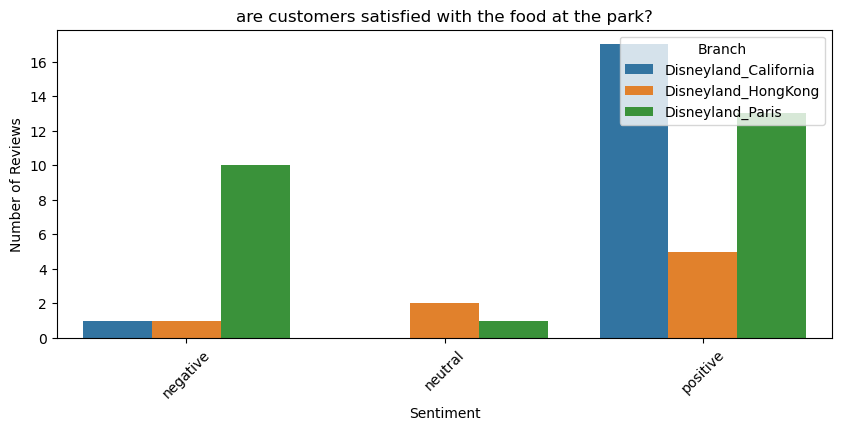

In [51]:
review_sentiment_for_query(table, embedding_model, query3, n_results=50)

Things don't fare as well when it comes to satisfaction on the food at each branch, we see a lot more negative food related reviews especially for Disneyland Paris.

##### Guest satisfaction with staff

In [52]:
query4 = "what did guests think of the staff?"

0    Visited the Park today   20 4   and can conclude that they simply let too many people in. Already at opening, queues at the attractions where 1 hour plus. At midday   the so called fast track was ...
1                                                                                             I wish they had better food restaurant choices, but the attractions make up for this deficit so it's all good.
2    We found this park to provide family friendly fun with a variety of shows and rides. We pre paid our tickets to save time which was a benefit and were glad we paid extra for the park hopper ticket...
Name: Review_Text, dtype: object


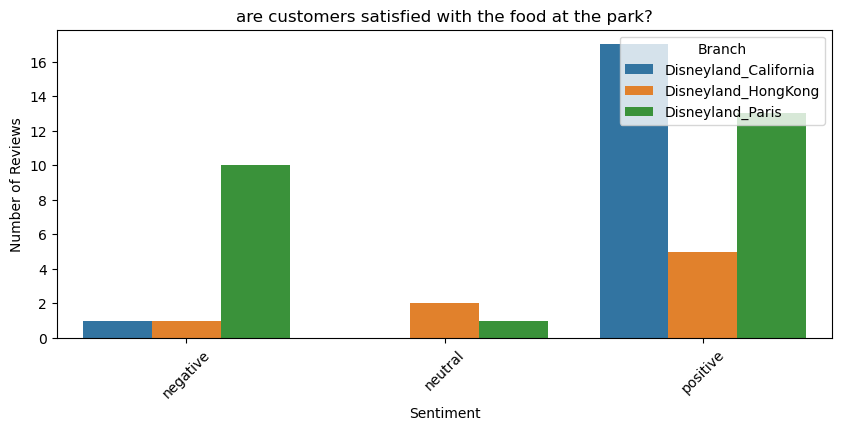

In [53]:
review_sentiment_for_query(table, embedding_model, query4, n_results=50)

Similarly for satisfaction with the staff - the most amount of negative reviews are coming for Disneyland Paris with less for California and none for Hong Kong.

Of course we took a subset of data - just 150 of the 42,000 reviews so to get more meaningful insights it would be a good idea to run the analysis on the full dataset.

## 6. Delete the KDB.AI Table

Once finished with the table, it is best practice to drop it.

In [54]:
table.drop()

True